## DECODING GOOGLE NEWS ARTICLES 
### need to remove duplicates from datasets!


In [1]:
import pandas as pd
#import geopandas as gpd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
import requests
import bs4
from bs4 import BeautifulSoup
import re
#import lxml.etree

#pip install geopandas
#pip install spacy
#python -m spacy download en_core_web_sm
#pip install lxml
#pip install parser-libraries 


In [2]:
#rz = pd.read_csv("full_rizz.csv", sep = ";")


# read in the dataset 
df = pd.read_json('animal_news_database.json', lines = True)
# Drop Twitter handles as they are not species names
df = df[df.scientific_name.str.contains('@') == False]
df.reset_index(drop = True, inplace = True)


df = df.drop(['_id'], axis=1)

# Explode the articles column
s = df['articles'].map(dict.values).explode()
# NaN values need to be droppped
s = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
df_full = df.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))

# Processing for articles       
# keep only unique article instances
df_media = df_full.drop_duplicates(subset=['text'])
# Transform date column into DateTime
df_media["date"] = df_media["date"].apply(pd.to_datetime)
# Sort by oldest to newest
df_media = df_media.sort_values(by="date")
# reset index
df_media.reset_index(drop = True, inplace = True)
# Remove any rows with blank data for the text column
df_media = df_media[df_media['text'].notna()]

/tmp/ipykernel_59/2430195414.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_media["date"] = df_media["date"].apply(pd.to_datetime)


In [7]:
"""Decode encoded Google News entry URLs."""
import base64
import functools
import re

# Ref: https://stackoverflow.com/a/59023463/

_ENCODED_URL_PREFIX = "https://news.google.com/articles/"
_ENCODED_URL_RE = re.compile(fr"^{re.escape(_ENCODED_URL_PREFIX)}(?P<encoded_url>[^?]+)")
_DECODED_URL_RE = re.compile(rb'^\x08\x13".+?(?P<primary_url>http[^\xd2]+)\xd2\x01')


@functools.lru_cache(2048)
def _decode_google_news_url(url: str) -> str:
    match = _ENCODED_URL_RE.match(url)
    encoded_text = match.groupdict()["encoded_url"]  # type: ignore
    encoded_text += "==="  # Fix incorrect padding. Ref: https://stackoverflow.com/a/49459036/
    decoded_text = base64.urlsafe_b64decode(encoded_text)

    match = _DECODED_URL_RE.match(decoded_text)
    primary_url = match.groupdict()["primary_url"]  # type: ignore
    primary_url = primary_url.decode()
    return primary_url


def decode_google_news_url(url: str) -> str:  # Not cached because not all Google News URLs are encoded.
    """Return Google News entry URLs after decoding their encoding as applicable."""
    return _decode_google_news_url(url) if url.startswith(_ENCODED_URL_PREFIX) else url

In [8]:
# Create an empty list for the urls
urls = []

# loop through the urls in the column that contains links to googlenews articles
for url in df_media['link']:
    try:
        new = decode_google_news_url(url)
        urls.append(new)
    
    # Attribute error caused by a faulty link will be removed from dataset
    except AttributeError:
        df_media.drop(df_media.loc[df_media.link == url].index, inplace = True)

# After dropping rows we will need to reset the index
df_media = df_media.reset_index(drop=True)

In [12]:
# The lengths of the list and dataframe will be the same, as will their order
# We can concatenate into a new dataframe
df_update = pd.concat([df_media, pd.DataFrame({'url':urls})], axis=1)
# Store the dataframe 
df_update.to_csv("csv/animals_exploded.csv", sep = ';', index = False)

## SHARECOUNT RETRIEVAL HERE

In [2]:
df_update = pd.read_csv("articles-w-full_sharecount.csv", sep = "~")

In [3]:
len(df_update)

10692

In [10]:
df_update

,common_name,scientific_name,distribution,iucn_status,date_saved,text,title,link,image,date,ner,url,sharecount,shares,reactions,comments
0,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,"TEMPO.CO, Jakarta - Holding a huge appeal for ...",Lampung Holds Huge Appeal for International To...,https://news.google.com/articles/CBMiU2h0dHA6L...,https://statik.tempo.co/data/2015/02/01/id_366...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Holding a huge ...",http://en.tempo.co/read/786937/lampung-holds-h...,0.0,0.0,0.0,0.0
1,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,"TEMPO.CO, Jakarta - Director of the Biodiversi...",Javan Rhinos to be Transferred to Cikepuh Wild...,https://news.google.com/articles/CBMiWmh0dHBzO...,https://statik.tempo.co/data/2011/12/29/id_100...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Director of the...",https://en.tempo.co/read/878302/javan-rhinos-t...,0.0,0.0,0.0,0.0
2,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,"TEMPO.CO, East Lampung - President Joko Widodo...",Jokowi Names Sumatran Rhino `Delilah`,https://news.google.com/articles/CBMiQ2h0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,"[{'sent': 'TEMPO.CO, East Lampung - President ...",https://en.tempo.co/read/791199/jokowi-names-s...,0.0,0.0,0.0,0.0
3,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,"TEMPO.CO, Nairobi - The world`s last male nort...",World`s Last Male Northern White Rhino Dies,https://news.google.com/articles/CBMiSmh0dHBzO...,https://statik.tempo.co/data/2017/08/23/id_635...,1970-01-01,"[{'sent': 'TEMPO.CO, Nairobi - The world`s las...",https://en.tempo.co/read/916815/worlds-last-ma...,0.0,0.0,0.0,0.0
4,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,"TEMPO.CO, Phnom Penh - Wildlife researchers in...",Cambodia Conservationists Find Rare Cache of C...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://statik.tempo.co/data/2014/11/25/id_346...,1970-01-01,"[{'sent': ""TEMPO.CO, Phnom Penh - Wildlife res...",https://www.tempo.co/read/887698/cambodia-cons...,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Grizzly Bear,Ursus arctos,"Afghanistan, Albania, Armenia, Austria, Azerba...",Least Concern,2020-06-18,Volunteer to help with crowds at Wyoming grizz...,Volunteer to help with crowds at Wyoming grizz...,https://news.google.com/articles/CBMiaWh0dHBzO...,https://s.hdnux.com/photos/01/12/22/44/1947472...,2020-05-30,[{'sent': 'Volunteer to help with crowds at Wy...,https://www.michigansthumb.com/news/article/Vo...,0.0,NaN,NaN,NaN
10688,Irrawaddy Dolphin,Orcaella brevirostris,"Australia, Bangladesh, Brunei Darussalam, Camb...",EN,2020-06-18,"In a unique initiative, researchers from the I...",IIT researchers help Chilika Lake in Odisha to...,https://news.google.com/articles/CBMiiwFodHRwc...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,"[{'sent': 'In a unique initiative, researchers...",https://www.deccanherald.com/national/east-and...,0.0,NaN,NaN,NaN
10689,Panther,Panthera pardus,"Afghanistan, Algeria, Angola, Armenia, Azerbai...",VU,2020-06-18,Lonzo Ball is never one to shy away from an op...,"Lonzo Ball jokingly compares JJ Redick, Jrue H...",https://news.google.com/articles/CBMihAFodHRwc...,https://usatlonzowire.files.wordpress.com/2020...,2020-05-31,[{'sent': 'Lonzo Ball is never one to shy away...,https://lonzowire.usatoday.com/2020/05/30/lonz...,0.0,NaN,NaN,NaN
10690,Lion-tailed Macaque,Macaca silenus,India,Endangered,2020-06-18,"During the nation-wide lockdown, most governme...",Flood of approvals by wildlife board sets the ...,https://news.google.com/articles/CBMiemh0dHBzO...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,[{'sent': 'But this nation-wide inactivity has...,https://www.deccanherald.com/specials/insigh

In [6]:
# From Sharecount API 
# 10,000 quota per day 
from requests.structures import CaseInsensitiveDict

sharecount = []
for url in df_update['url'][9500:]: 
    
    api = "https://api.sharedcount.com/v1.1?apikey=2a0336186dc8f5740fef9c1eb81947d66119c29f&url=" + url
                                                   
    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"
    
    resp = requests.get(api, headers=headers)
    details = resp.json()
    #for n in range(len(details)):
        #count = details[n]['Facebook']['share_count']
        #print(count)
 
    
    shares = details['Facebook']['share_count']
    reactions = details['Facebook']['reaction_count']
    comments = details['Facebook']['comment_count']
    
    data = {'shares': shares, 'reactions': reactions, 'comments': comments}
    
    sharecount.append(data)
        
   # except KeyError:
       # print(url, details)
        #rz.drop(rz.loc[rz.url == url].index, inplace = True)


In [7]:
len(sharecount)

1192

In [14]:
# If first time retrieving data from SharedCount
df_update = pd.concat([df_update, pd.DataFrame(sharecount)], axis=1)

In [22]:
# Use this method if some data already gathered and you need to populate the end of the columns that have most of the data 
tail_sharecount = pd.DataFrame(sharecount).set_axis(range(9500, 10692))
tail_sharecount

,shares,reactions,comments
9500,143,724,169
9501,0,0,0
9502,722,3209,439
9503,5,140,31
9504,0,0,0
...,...,...,...
10687,0,0,0
10688,0,0,0
10689,0,0,0
10690,375,1337,109


In [20]:
df_update['shares'].iloc[9500:].fillna(tail_sharecount['shares'], inplace = True)
df_update['reactions'].iloc[9500:].fillna(tail_sharecount['reactions'], inplace = True)
df_update['comments'].iloc[9500:].fillna(tail_sharecount['comments'], inplace = True)

In [21]:
df_update

,common_name,scientific_name,distribution,iucn_status,date_saved,text,title,link,image,date,ner,url,sharecount,shares,reactions,comments
0,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,"TEMPO.CO, Jakarta - Holding a huge appeal for ...",Lampung Holds Huge Appeal for International To...,https://news.google.com/articles/CBMiU2h0dHA6L...,https://statik.tempo.co/data/2015/02/01/id_366...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Holding a huge ...",http://en.tempo.co/read/786937/lampung-holds-h...,0.0,0.0,0.0,0.0
1,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,"TEMPO.CO, Jakarta - Director of the Biodiversi...",Javan Rhinos to be Transferred to Cikepuh Wild...,https://news.google.com/articles/CBMiWmh0dHBzO...,https://statik.tempo.co/data/2011/12/29/id_100...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Director of the...",https://en.tempo.co/read/878302/javan-rhinos-t...,0.0,0.0,0.0,0.0
2,White-winged Wood Duck,Asarcornis scutulata,"Bangladesh, Cambodia, India, Indonesia, Lao Pe...",EN,2020-06-18,"TEMPO.CO, East Lampung - President Joko Widodo...",Jokowi Names Sumatran Rhino `Delilah`,https://news.google.com/articles/CBMiQ2h0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,"[{'sent': 'TEMPO.CO, East Lampung - President ...",https://en.tempo.co/read/791199/jokowi-names-s...,0.0,0.0,0.0,0.0
3,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,"TEMPO.CO, Nairobi - The world`s last male nort...",World`s Last Male Northern White Rhino Dies,https://news.google.com/articles/CBMiSmh0dHBzO...,https://statik.tempo.co/data/2017/08/23/id_635...,1970-01-01,"[{'sent': 'TEMPO.CO, Nairobi - The world`s las...",https://en.tempo.co/read/916815/worlds-last-ma...,0.0,0.0,0.0,0.0
4,Javan Gibbon,Hylobates moloch,Indonesia,Endangered,2020-06-18,"TEMPO.CO, Phnom Penh - Wildlife researchers in...",Cambodia Conservationists Find Rare Cache of C...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://statik.tempo.co/data/2014/11/25/id_346...,1970-01-01,"[{'sent': ""TEMPO.CO, Phnom Penh - Wildlife res...",https://www.tempo.co/read/887698/cambodia-cons...,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Grizzly Bear,Ursus arctos,"Afghanistan, Albania, Armenia, Austria, Azerba...",Least Concern,2020-06-18,Volunteer to help with crowds at Wyoming grizz...,Volunteer to help with crowds at Wyoming grizz...,https://news.google.com/articles/CBMiaWh0dHBzO...,https://s.hdnux.com/photos/01/12/22/44/1947472...,2020-05-30,[{'sent': 'Volunteer to help with crowds at Wy...,https://www.michigansthumb.com/news/article/Vo...,0.0,0.0,0.0,0.0
10688,Irrawaddy Dolphin,Orcaella brevirostris,"Australia, Bangladesh, Brunei Darussalam, Camb...",EN,2020-06-18,"In a unique initiative, researchers from the I...",IIT researchers help Chilika Lake in Odisha to...,https://news.google.com/articles/CBMiiwFodHRwc...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,"[{'sent': 'In a unique initiative, researchers...",https://www.deccanherald.com/national/east-and...,0.0,0.0,0.0,0.0
10689,Panther,Panthera pardus,"Afghanistan, Algeria, Angola, Armenia, Azerbai...",VU,2020-06-18,Lonzo Ball is never one to shy away from an op...,"Lonzo Ball jokingly compares JJ Redick, Jrue H...",https://news.google.com/articles/CBMihAFodHRwc...,https://usatlonzowire.files.wordpress.com/2020...,2020-05-31,[{'sent': 'Lonzo Ball is never one to shy away...,https://lonzowire.usatoday.com/2020/05/30/lonz...,0.0,0.0,0.0,0.0
10690,Lion-tailed Macaque,Macaca silenus,India,Endangered,2020-06-18,"During the nation-wide lockdown, most governme...",Flood of approvals by wildlife board sets the ...,https://news.google.com/articles/CBMiemh0dHBzO...,https://www.deccanherald.com/sites/dh/files/ar...,2020-05-31,[{'sent': 'But this nation-wide inactivity has...,https://www.deccanherald.com/specials/insigh

In [23]:
df_update.to_csv('csv/articles-w-full_sharecount.csv', sep = '~', index = False)

In [34]:
top20articles = df_update.sort_values(by="shares", ascending = False).nlargest(columns = "shares", n=20)
top20articles.sort_values(by="date")

,common_name,scientific_name,distribution,iucn_status,date_saved,text,title,link,image,date,ner,url,sharecount,shares,reactions,comments
814,Orang-utan,Pongo pygmaeus,"Brunei Darussalam, Indonesia, Malaysia",CR,2020-06-18,Sign up to FREE email alerts from Mirror - dai...,Pregnant orang-utan pictured clinging to final...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://i2-prod.mirror.co.uk/incoming/article1...,2013-05-18,[{'sent': 'Sign up to FREE email alerts from M...,https://www.mirror.co.uk/news/world-news/pregn...,122895.0,122930.0,673542.0,64810.0
3362,Ocelot,Leopardus pardalis,"Argentina, Belize, Bolivia (Plurinational Stat...",Least Concern,2020-06-18,A wildlife refuge in South Texas is home to a ...,Texas Ocelot Den Found for First Time in Two D...,https://news.google.com/articles/CBMiUGh0dHBzO...,https://cdn0.wideopencountry.com/wp-content/up...,2016-12-27,[{'sent': 'KVEO-TV reports biologists at Lagun...,https://www.wideopencountry.com/first-known-oc...,30406.0,30375.0,193288.0,12131.0
3490,African Slender-snouted Crocodile,Crocodylus cataphractus,"Angola, Benin, Burkina Faso, Burundi, Cameroon...",NaN,2020-06-18,ABIDJAN (Reuters) - When conservation biologis...,"Fate of Africa's newest, rarest crocodile tied...",https://news.google.com/articles/CBMiNGh0dHBzO...,https://s1.reutersmedia.net/resources/r/?m=02&...,2017-02-10,"[{'sent': 'ABIDJAN (Reuters) -', 'ents': {'ORG...",https://af.reuters.com/article/topNews/idAFKBN...,46123.0,46221.0,18453.0,7972.0
5017,White-bellied Pangolin,Manis tricuspis,"Angola, Benin, Burkina Faso, Cameroon, Central...",NaN,2020-06-18,Is “vaquita” the name of an endangered species...,"Is This Clothing, Food, or an Endangered Speci...",https://news.google.com/articles/CBMiVmh0dHBzO...,https://www.nationalgeographic.com/content/dam...,2018-05-18,[{'sent': 'If you answered “endangered species...,https://www.nationalgeographic.com/news/2018/0...,46244.0,46278.0,28683.0,4956.0
5437,Southern Pudu,Pudu puda,"Argentina, Chile",Near Threatened,2020-06-18,"As a child, you’re taught your zebras and your...",Meet these 30 obscure animals you probably hav...,https://news.google.com/articles/CBMiVmh0dHBzO...,https://cdn.science101.com/wp-content/uploads/...,2018-09-04,[{'sent': 'But with about a million known anim...,https://www.science101.com/meet-these-30-obscu...,17044.0,17044.0,35713.0,4343.0
5556,Common ostrich,Struthio camelus,"Algeria, Angola, Australia, Bahrain, Botswana,...",Least Concern,2020-06-18,Imagine a startled pigeon flying at your head....,Quiz: What animal does each eye belong to?,https://news.google.com/articles/CBMiVmh0dHBzO...,https://www.nationalgeographic.com/content/dam...,2018-10-04,"[{'sent': ""But human eyes, while magnificent, ...",https://www.nationalgeographic.com/animals/201...,51326.0,51363.0,54391.0,10193.0
5739,Sperm Whale,Physeter macrocephalus,"American Samoa, Angola, Anguilla (United Kingd...",VU,2020-06-18,This dead sperm whale was found washed up on a...,"Found, Inside Dead Sperm Whale: 100 Plastic Cu...",https://news.google.com/articles/CBMiQmh0dHBzO...,https://cdn.mos.cms.futurecdn.net/XggLrRfTAk6T...,2018-11-21,[{'sent': 'This dead sperm whale was found was...,https://www.livescience.com/64139-sperm-whale-...,260002.0,260011.0,1195680.0,138201.0
5838,Hanuman Langur,Semnopithecus entellus,"Bangladesh, India, Nepal, Pakistan",Least Concern,2020-06-18,It was a regular day when Peera Ram was travel...,This Roadside Mechanic from Rajasthan Has Resc...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://www.thebetterindia.com/wp-content/uplo...,2018-12-18,[{'sent': 'It was a regular day when Peera Ram...,https://www.thebetterindia.com/167113/rajastha...,28785.0,28798.0,233646.0,6079.0
5836,Hanuman Langur,Semnopithecus entellus,"Bangladesh, India, Nepal, Pakistan",Least Concern,2020-06-18,It was a regular day when Peera Ram was travel...,This Roadside Mechanic from Rajasthan Has Resc...,https://news.google.com/articles/CBMiXGh0dHBzO...,https://www.thebet

In [25]:
top20fb = df_update.groupby('scientific_name')['shares'].sum().nlargest(20).reset_index()

In [26]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

In [27]:
# Do the same for the entire dataframe
top20fb = top20fb.merge(cites1, on = 'scientific_name', how = 'left').drop_duplicates().reset_index(drop=True)
top20fb

,scientific_name,shares,Kingdom,Class,Order,Family,Genus,Species,Listing,NativeDistributionFullNames,Extinct_Distribution
0,Physeter macrocephalus,264120.0,Animalia,Mammalia,Cetacea,Physeteridae,Physeter,macrocephalus,I,"American Samoa,Angola,Anguilla (United Kingdom...",NaN
1,Pongo pygmaeus,130767.0,Animalia,Mammalia,Primates,Hominidae,Pongo,pygmaeus,I,"Indonesia,Malaysia",Brunei Darussalam
2,Leopardus pardalis,99296.0,Animalia,Mammalia,Carnivora,Felidae,Leopardus,pardalis,I,"Argentina,Belize,Bolivia (Plurinational State ...",NaN
3,Manis tricuspis,63789.0,Animalia,Mammalia,Pholidota,Manidae,Manis,tricuspis,I,"Angola,Benin,Cameroon,Congo,Côte d'Ivoire,Demo...",NaN
4,Semnopithecus entellus,59604.0,Animalia,Mammalia,Primates,Cercopithecidae,Semnopithecus,entellus,I,"Bangladesh,India,Nepal,Pakistan",NaN
5,Struthio camelus,56344.0,Animalia,Aves,Struthioniformes,Struthionidae,Struthio,camelus,I,"Angola,Botswana,Cameroon,Central African Repub...","Algeria,Bahrain,Burkina Faso,Iraq,Israel,Jorda..."
6,Panthera uncia,48192.0,Animalia,Mammalia,Carnivora,Felidae,Panthera,uncia,I,"Afghanistan,Bhutan,China,India,Kazakhstan,Kyrg...",NaN
7,Crocodylus cataphractus,46683.0,Animalia,Reptilia,Crocodylia,Crocodylidae,Crocodylus,cataphractus,I,"Angola,Benin,Burkina Faso,Burundi,Cameroon,Cen...",NaN
8,Chelonoidis niger,36560.0,Animalia,Reptilia,Testudines,Testudinidae,Chelonoidis,niger,I,Ecuador,NaN
9,Varanus komodoensis,32636.0,Animalia,Reptilia,Sauria,Varanidae,Varanus,komodoensis,I,Indonesia,NaN


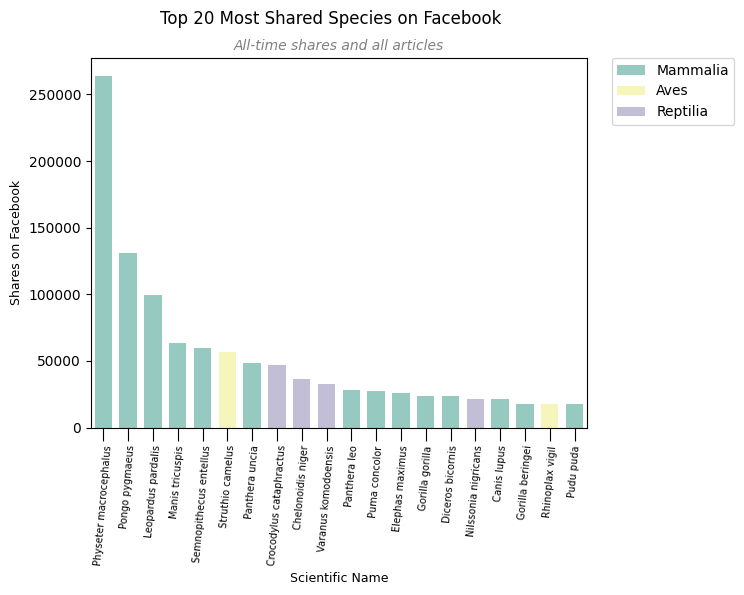

In [35]:
import seaborn as sns

ax = sns.barplot(
    x = 'scientific_name',
    y = 'shares',
    hue = 'Class',
    data = top20fb, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Scientific Name', fontsize=9)
ax.set_ylabel('Shares on Facebook', fontsize=9)


# Add suptitle above the title
plt.suptitle("Top 20 Most Shared Species on Facebook\n", fontsize=12)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('All-time shares and all articles', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('figures/top_20_species_facebook.png', bbox_inches = 'tight')

In [18]:
# If only retreived sharecount so there is only a list of shares 
all_articles_sharecount = pd.concat([df_update, pd.DataFrame({'sharecount':sharecount})], axis=1) 

In [21]:
## Directly retrieveing from Facebook
# Has lower request limit

from requests.structures import CaseInsensitiveDict
import requests

sharecount = []
for url in df_update['url'][:100]:
    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"
    
    token = "EAAIxJUBe0zYBAOKUVYhZCHWRlZBm0Pj4M8DGka4LvaFuyeKCMLF8NG2rGtamLjwAMZBSrMFWPY6ZAnpZAihDhP7wjs9drlJ4W8C1ZCCyguI2Kg8rxgfUVrv22sFrcNLXYS1PYZAZALqr2ZB4bLpKMYHC7yGA7lXF8tf3G6BOI6YdQArlLt5bzY6TMZC73HTBr4ztpbRkSefUXGFZB9TTgbyZBL8nY8sSq5YuZAFy9owthwenPOMvK3K9ZACtP5hBiY2GfV4GcZD"
    resp = requests.get(f'https://graph.facebook.com/?id={url}&fields=engagement&access_token={token}', headers=headers).json()
    #print(resp)
    
    #break
    try:
        fb_shares = (resp['engagement']['share_count'])
        sharecount.append(fb_shares)
    except KeyError:
        print("API Limit exceeded")
        
        break
    


API Limit exceeded
